In [1]:
%matplotlib widget
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
print(os.getpid())
%cd ../../

import pylib.mix as mix
import cvxpy as cp
import pylib.qucf_read as qucf_r
import pylib.measurement as mse

from matplotlib import colors

colors_ = ["blue", "red", "green", "gray", "black"]

11377
/media/work/docs/codes/QuCF/scripts-py


In [2]:
for i in range(100):
    plt.close()

In [3]:
# -----------------------------------------------------
# --- Canonical coordinate and some constants ---
# -----------------------------------------------------
xmax_, Nx_ = 10.0, 2001

x_ = np.linspace(-xmax_, xmax_, Nx_)
dx_ = np.diff(x_)[0]

# --- Planck constant: h / 2pi, h = 6.6261e−34 J*s ---
hp_ = 1.0 

In [4]:
# -----------------------------------------------------
# --- Harmonic oscillator ---
# -----------------------------------------------------
def harm_oscillator(x, dx, Nx, Ca, w):
    H = np.zeros((Nx, Nx))
    V = np.zeros(Nx) 

    coef0 = hp_**2 / (2.*Ca * dx**2)
    coef1 = 0.5 * Ca * w**2 

    V_func = lambda x: coef1 * x**2

    for ir in range(Nx):
        # --- Potential ---
        V[ir] = V_func(x[ir])
        # coef1 * x[ir] * x[ir]

        # --- Hamiltonian ---
        if ir == 0:
            H[ir, Nx-1] = -coef0
        else:
            H[ir, ir-1] = -coef0

        if ir == (Nx-1):
            H[ir, 0] = -coef0
        else:
            H[ir, ir+1] = -coef0
        H[ir, ir] = 2. * coef0 + V[ir]

    return H, V, V_func, "harm-osc"
# ---------------------------------------------------------------
Ca_ = 1.2 # capacitance
w_  = 3.8 # frequency, 1/sqrt(LC)
H_, V_, V_func_, str_H_ = harm_oscillator(x_, dx_, Nx_, Ca_, w_)

In [5]:
# ------------------------------------------------------------
# --- Compute eigenvalues and eigenvectors ---
# ------------------------------------------------------------
def compute_eig(H):
    eigVals, eigVecs = np.linalg.eig(H)

    eigVals_sorted = np.sort(eigVals)
    ids_sort = np.argsort(eigVals)

    eigVecs_sorted = eigVecs[:,ids_sort]

    return eigVals_sorted, eigVecs_sorted
# ------------------------------------------------------------
def compute_anharmonicity(eigVals):
    Nx = len(eigVals)
    dw = np.zeros(Nx-1)
    for ix in range(Nx-1):
        dw[ix] = eigVals[ix+1] - eigVals[ix]

    anh = np.zeros(Nx-2)
    for ix in range(Nx-2):
        anh[ix] = dw[ix+1] - dw[ix]    
    return dw, anh
# ------------------------------------------------------------
eigVals_sorted_, eigVecs_sorted_ = compute_eig(H_)
dw_, anh_ = compute_anharmonicity(eigVals_sorted_)
print("Done")

Done


In [6]:
# ------------------------------------------------------------
# --- Print eigenvalues and anharmonicity ---
# ------------------------------------------------------------
def print_eigvals_via_diag_matrix(M, eigVecs_sorted, N_first_eigvals, ff_print):

    # --- matrix diagonalization ---
    Pinv = np.linalg.inv(eigVecs_sorted)
    M_diagonalized = np.dot(np.dot(Pinv, M), eigVecs_sorted)

    # --- extract elements on the main diagonal (eigenvalues) ---
    H_diag_diag = np.diag(M_diagonalized)

    # --- print several first diagonal elements ---
    mix.print_array(H_diag_diag[:N_first_eigvals], ff=ff_print, n_in_row = N_first_eigvals)
    return
# -------------------------------------------------------------------
Ne_print = 20
ff_print = [6, 3, "f"]

print("--- {:d} first eigenvalues ---".format(Ne_print))
mix.print_array(eigVals_sorted_[:Ne_print], ff=ff_print, n_in_row = Ne_print)

print("\n--- {:d} first eigenvalues (via diagonalization) ---".format(Ne_print))
print_eigvals_via_diag_matrix(H_, eigVecs_sorted_, Ne_print, ff_print)

print("\n--- energy differences of first {:d} eigenvalues ---".format(Ne_print))
mix.print_array(dw_[:Ne_print], ff=ff_print, n_in_row = Ne_print)

print("\n--- anharmonicity of first {:d} eigenvalues ---".format(Ne_print))
mix.print_array(anh_[:Ne_print], ff=[12, 3, "e"], n_in_row = Ne_print)

del Ne_print, ff_print

--- 20 first eigenvalues ---
 1.900  5.700  9.499 13.299 17.098 20.897 24.695 28.494 32.292 36.090 39.888 43.686 47.483 51.280 55.077 58.874 62.670 66.467 70.263 74.059 

--- 20 first eigenvalues (via diagonalization) ---
 1.900  5.700  9.499 13.299 17.098 20.897 24.695 28.494 32.292 36.090 39.888 43.686 47.483 51.280 55.077 58.874 62.670 66.467 70.263 74.059 

--- energy differences of first 20 eigenvalues ---
 3.800  3.800  3.799  3.799  3.799  3.799  3.798  3.798  3.798  3.798  3.798  3.797  3.797  3.797  3.797  3.797  3.796  3.796  3.796  3.796 

--- anharmonicity of first 20 eigenvalues ---
  -2.166e-04   -2.166e-04   -2.167e-04   -2.167e-04   -2.167e-04   -2.167e-04   -2.167e-04   -2.168e-04   -2.168e-04   -2.168e-04   -2.168e-04   -2.168e-04   -2.169e-04   -2.169e-04   -2.169e-04   -2.169e-04   -2.169e-04   -2.169e-04   -2.170e-04   -2.170e-04 


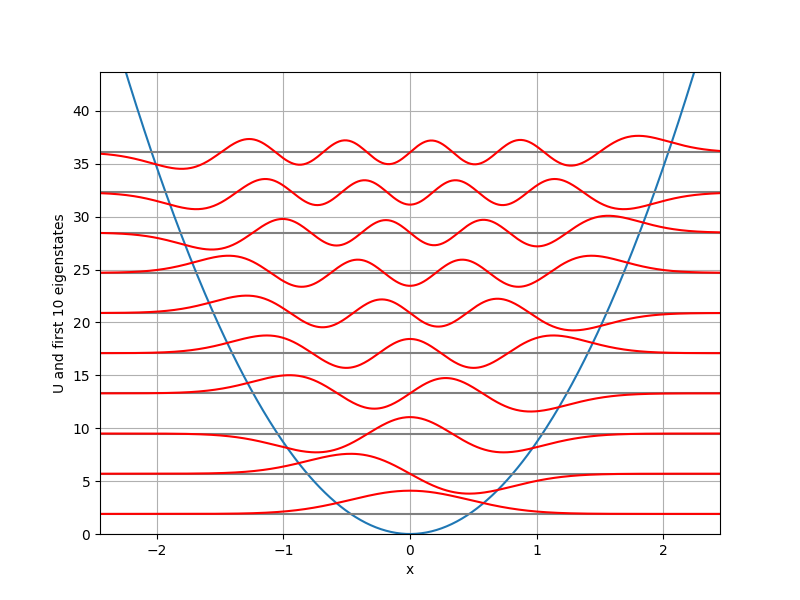

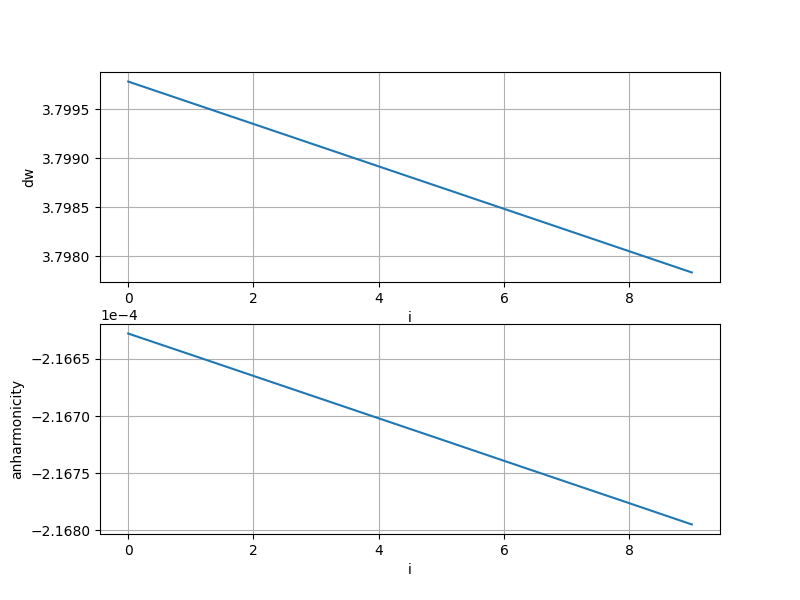

In [7]:
# ------------------------------------------------------------
# --- Plot eigenvalues, anharmonicity and eigenvectors ---
# ------------------------------------------------------------
from scipy.optimize import fsolve
def plot_eig_anh(N_eig, resc_eigv = 4.0, coef_x_lim = 1.2, flag_eigstates = True):
    def findIntersection(fun1,fun2,x0):
        return fsolve(lambda x : fun1(x) - fun2(x),x0)
    # ------------------------------------------------------------
    resc_eigv = resc_eigv * (N_eig/2.)  # rescaling of eigenstates
    coef_x_lim = coef_x_lim # width of drawn area for eigenstates within a potenial well

    # # --------------------------------------------------
    # Vmax    = np.max(V_)
    # eig_ref = eigVals_sorted_[N_eig]

    # # --- Plot normalized eigenvalues ---
    # fig = plt.figure(figsize=(8, 6))
    # ax = fig.add_subplot(111)
    # ax.plot(x_, V_/Vmax, "-")

    # eigv_norm = np.array(eigVals_sorted_[:N_eig]) / eig_ref
    # for ii in range(N_eig):
    #     x_curr = np.abs(findIntersection(
    #         lambda x: eigv_norm[ii] * Vmax, V_func_, 0.0
    #     )[0])
    #     ax.hlines(eigv_norm[ii], -x_curr, x_curr, color="red")
    # ax.set_xlabel("x")
    # ax.set_ylabel("U-norm;   {:d} first eigVals-norm".format(N_eig))
    # ax.set_title("U-max = {:0.3e}, eig-ref = {:0.3e}".format(Vmax, eig_ref))
    # ax.grid()

    # --- Plot eigenvalues and eigenstates ---
    if flag_eigstates:
        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111)
        ax.plot(x_, V_, "-")
        for ii in range(N_eig):
            x_curr = np.abs(findIntersection(
                lambda x: eigVals_sorted_[ii], V_func_, 0.2
            )[0])
            ax.hlines(eigVals_sorted_[ii], -xmax_, xmax_, color="gray")

            eig_vec = resc_eigv * np.array(eigVecs_sorted_[:,ii]) 
            eig_vec += eigVals_sorted_[ii] * np.ones(Nx_)
            ax.plot(x_, eig_vec, "-", color="red")
        ax.set_xlabel("x")
        ax.set_ylabel("U and first {:d} eigenstates".format(N_eig))
        ax.set_xlim([-coef_x_lim * x_curr, coef_x_lim * x_curr])
        ax.set_ylim([0, eigVals_sorted_[N_eig+1]])
        ax.grid()

    # --- Plot energy-differences and anharomnicities ---
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(211)
    ax.plot(range(N_eig), dw_[:N_eig])
    ax.set_xlabel("i")
    ax.set_ylabel("dw")
    ax.grid()

    ax = fig.add_subplot(212)
    ax.plot(range(N_eig), anh_[:N_eig])
    ax.set_xlabel("i")
    ax.set_ylabel("anharmonicity")
    ax.ticklabel_format(axis='y', style='sci', scilimits=(-3,3))
    ax.grid()

    del N_eig
    return
# ----------------------------------------------------
plot_eig_anh(N_eig = 10, resc_eigv = 4.0, coef_x_lim = 1.2, flag_eigstates = True)

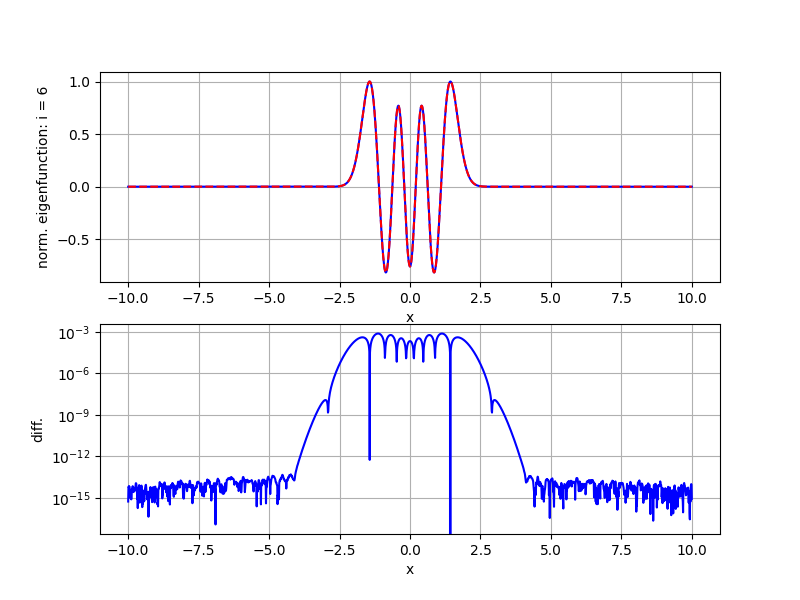

In [8]:
# ------------------------------------------------------------------
# --- Compare numerically computed and analytical eigenfunctions ---
# ------------------------------------------------------------------
import math
from scipy import special
def compare_eigfunction_with_analytics(id_to_plot):
    # --- analytical function ---
    coef_c = pow(Ca_ * w_/(np.pi * hp_), 0.25)
    coef_pol = np.sqrt(Ca_ * w_ / hp_)
    exp_func = np.exp(- Ca_ * w_ * x_**2/(2. * hp_))

    coef1 = 1./ np.sqrt(2.**id_to_plot * math.factorial(id_to_plot))
    He_pol = special.hermite(id_to_plot, monic=False)(coef_pol * x_)
    eigf_a = coef_c * coef1 * exp_func * He_pol

    eigf_a = eigf_a / np.max(np.abs(eigf_a))

    # --- num. function ---
    eigf_num = np.array(eigVecs_sorted_[:,id_to_plot])
    eigf_num /= np.max(np.abs(eigf_num))

    # --- correct the sign ---
    sign_func = 1.0
    if(np.sum(eigf_num * eigf_a) < 0):
        sign_func = -1

    # --- Plotting ---
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(211)
    ax.plot(x_, eigf_num, "-b")
    ax.plot(x_, sign_func * eigf_a,   "--r")
    ax.set_xlabel("x")
    ax.set_ylabel("norm. eigenfunction: i = {:d}".format(id_to_plot))
    ax.grid()

    ax = fig.add_subplot(212)
    ax.plot(x_, np.abs(eigf_num - sign_func * eigf_a), "-b")
    ax.set_yscale('log')
    ax.set_xlabel("x")
    ax.set_ylabel("diff.")
    ax.grid()
    return
# --------------------------------------------------------------------------
compare_eigfunction_with_analytics(id_to_plot = 6)